In [1]:
import numpy as np
import scanpy as sc
import torch

import matplotlib.pyplot as plt
from scarches.dataset.trvae.data_handling import remove_sparsity
from tranvae.model import EMBEDCVAE, TRANVAE
from sklearn.metrics import classification_report

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

%load_ext autoreload
%autoreload 2

In [2]:
unlabeled_strat = "batch"
cells_per_ct = 2000

# Model Params
latent_dim = 10
use_mmd = False

# Training Params
alpha_epoch_anneal = 1e6
eta = 1
tau = 0
clustering_res = 2
labeled_loss_metric = "dist"
unlabeled_loss_metric = "dist"
class_metric = "dist"

early_stopping_kwargs = {
    "early_stopping_metric": "val_classifier_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

cell_type_key = ["cell_type"]

In [6]:
DATA_DIR = '../data'
adata = sc.read(
    f'{DATA_DIR}/benchmark_pancreas_shrinked.h5ad'
)
condition_key = 'study'
reference = ["inDrop1", "inDrop2", "inDrop3", "inDrop4", "fluidigmc1", "smartseq2", "smarter"]
query = ["celseq", "celseq2"]

In [7]:
adata = remove_sparsity(adata)

indices = np.arange(len(adata))
#stratified label/unlabeled split
if unlabeled_strat == "batch":
    labeled_ind = indices[adata.obs.study.isin(reference)].tolist()
    labeled_adata = adata[adata.obs.study.isin(reference)].copy()
    unlabeled_adata = adata[adata.obs.study.isin(query)].copy()
if unlabeled_strat == "ct":
    labeled_ind = []
    cts = adata.obs[cell_type_key[0]].unique().tolist()
    for celltype in cts:
        ct_indices = indices[adata.obs[cell_type_key[0]].isin([celltype])]
        ct_sel_ind = np.random.choice(ct_indices, size=cells_per_ct, replace=False)
        labeled_ind += ct_sel_ind.tolist()
        print(celltype, len(ct_indices), len(ct_sel_ind), len(labeled_ind))
    unlabeled_ind = np.delete(indices, labeled_ind).tolist()
    labeled_adata = adata[labeled_ind].copy()
    unlabeled_adata = adata[unlabeled_ind].copy()

In [8]:
embed = EMBEDCVAE(
    adata=adata,
    condition_key=condition_key,
    inject_condition = ['encoder', 'decoder'],
    embedding_dim = 10,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim=latent_dim,
    use_mmd=use_mmd,
    labeled_indices=labeled_ind,
    unknown_ct_names=None
)

Encoder Architecture:
	Input Layer in, out and cond: 4000 128 10
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [9]:
tranvae = TRANVAE(
    adata=adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim=latent_dim,
    use_mmd=use_mmd,
    labeled_indices=labeled_ind,
    unknown_ct_names=None
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [10]:
embed_dec = EMBEDCVAE(
    adata=adata,
    condition_key=condition_key,
    inject_condition = ['decoder'],
    embedding_dim = 10,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim=latent_dim,
    use_mmd=use_mmd,
    labeled_indices=labeled_ind,
    unknown_ct_names=None
)

Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [11]:
tranvae.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=eta,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |████----------------| 20.0%  - val_loss: 1058.7840951773 - val_trvae_loss: 1058.7840951773
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 30 clusters.
 |███████-------------| 38.6%  - val_loss: 1058.8561636118 - val_trvae_loss: 1058.3906062200 - val_classifier_loss: 0.4655575065 - val_unlabeled_loss: 0.8614146251 - val_labeled_loss: 0.4646960978
ADJUSTED LR
 |█████████-----------| 47.4%  - val_loss: 1056.9593411959 - val_trvae_loss: 1056.5956139198 - val_classifier_loss: 0.3637333077 - val_unlabeled_loss: 0.7160401940 - val_labeled_loss: 0.3630172702
ADJUSTED LR
 |██████████----------| 50.2%  - val_loss: 1057.2009371244 - val_trvae_loss: 1056.8126784105 - val_classifier_loss: 0.3882588836 - val_unlabeled_loss: 0.6917956792 - val_labeled_loss: 0.3875670846
ADJUSTED LR
 |██████████----------| 51.6%  - val_loss: 1057.0169114333 - val_trvae_loss: 1056.6190185547 - val_classifier_loss: 0.3978984677 - val_unlab

[{'preds': array(['gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', ...,
       'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma'],
      dtype='<U18'), 'probs': array([0.12, 0.11, 0.12, 0.11, 0.12, 0.11, 0.12, ..., 0.11, 0.11, 0.11,
       0.1 , 0.11, 0.11, 0.13], dtype=float32)}]


... storing 'batch' as categorical


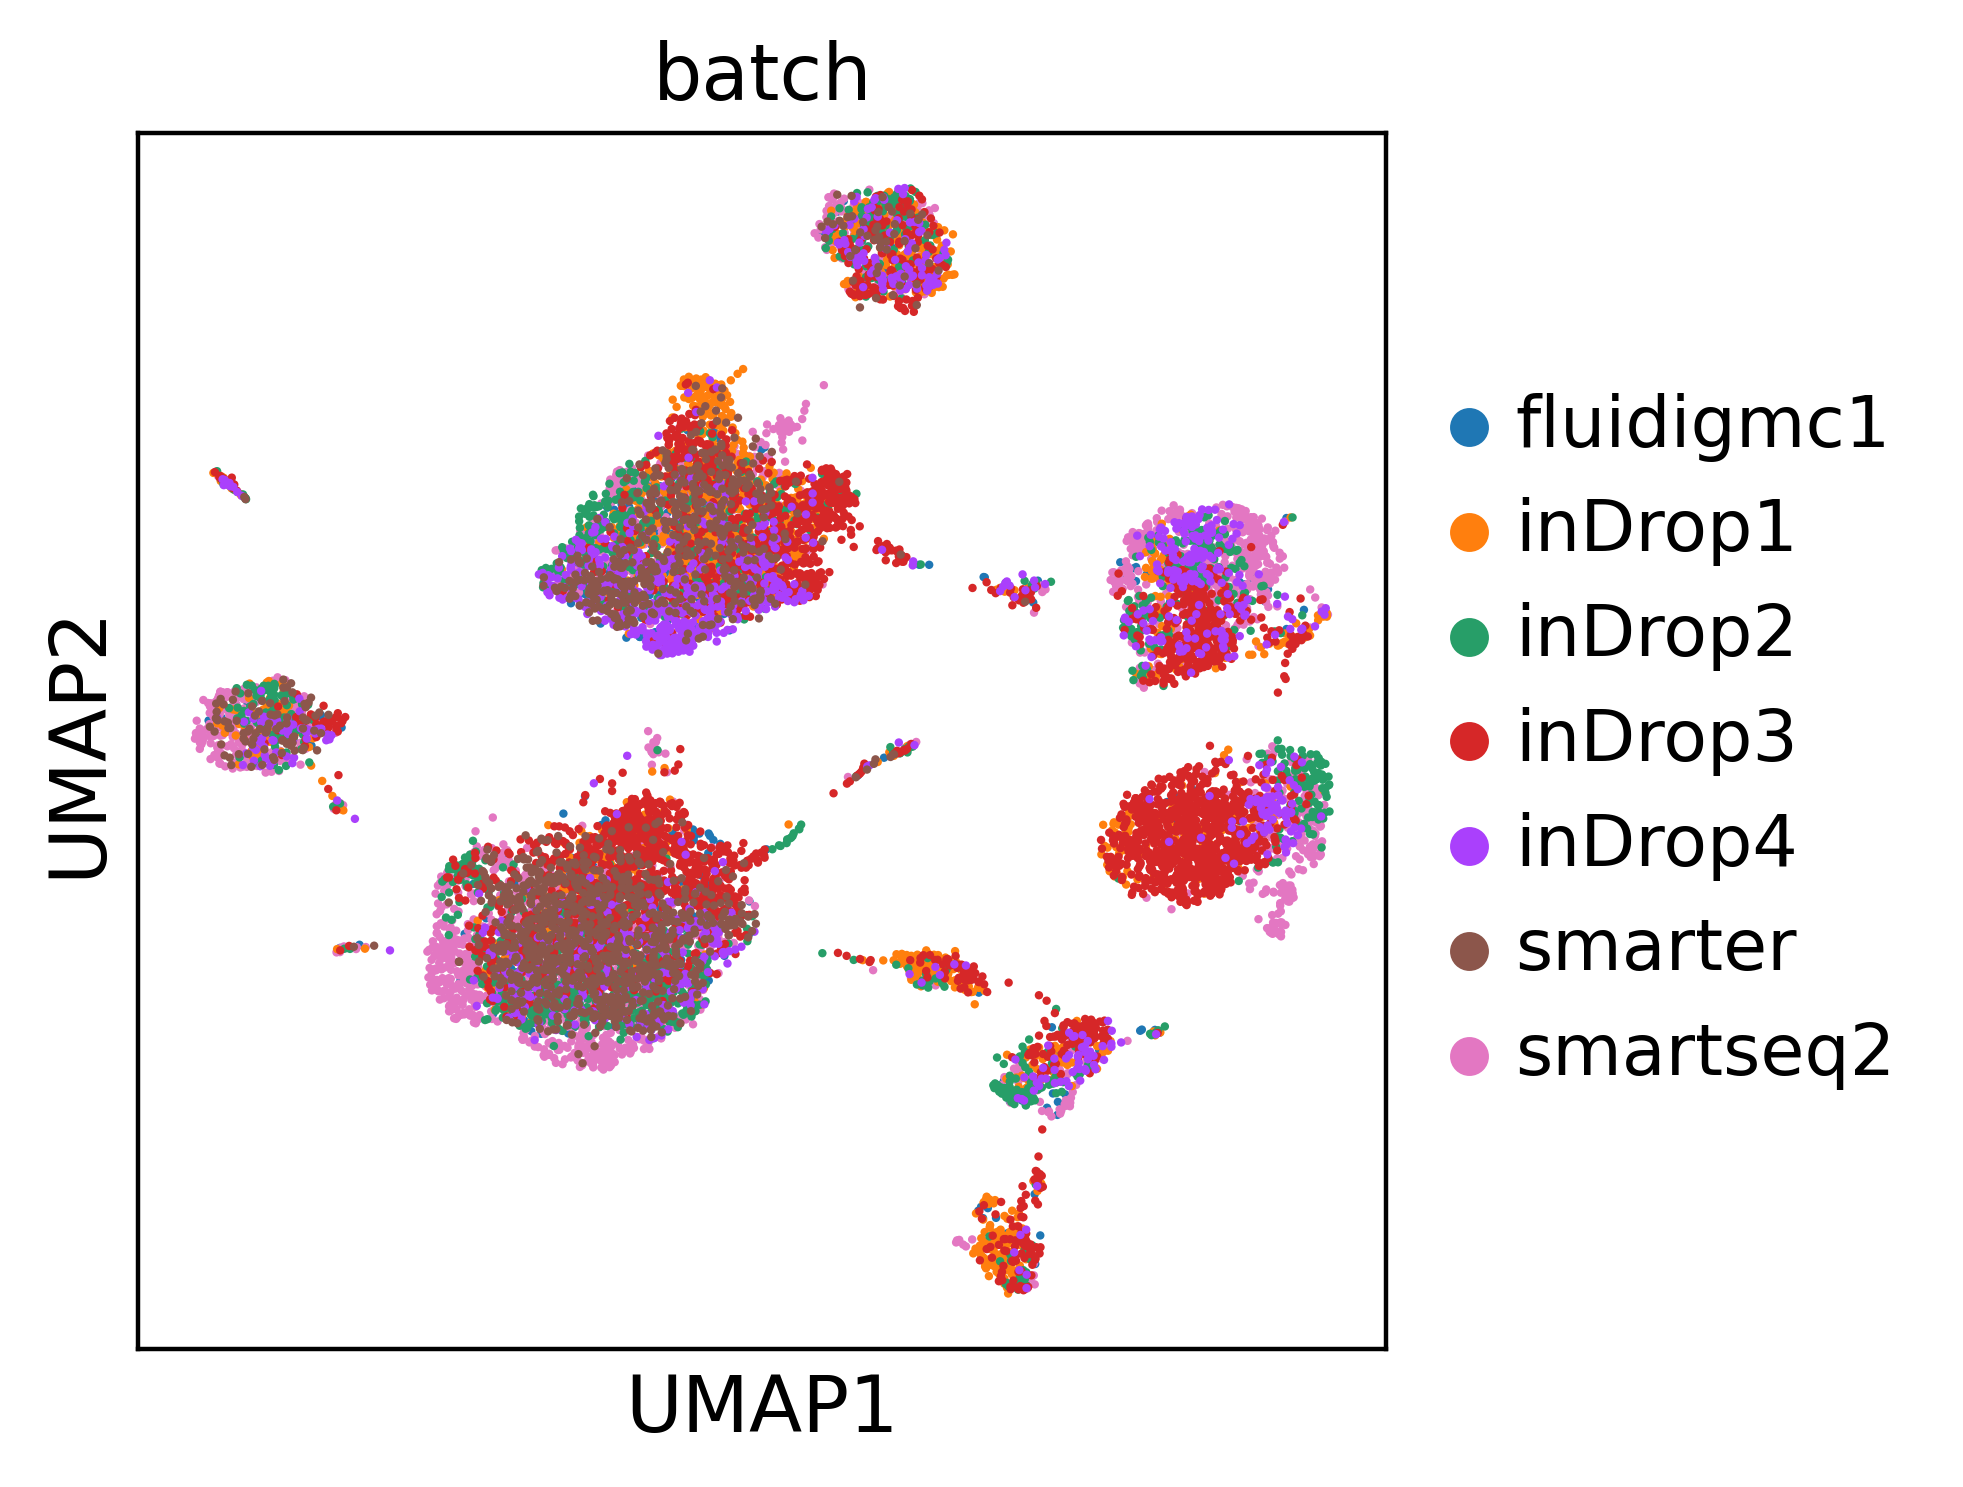

In [12]:
data_latent = tranvae.get_latent(
    labeled_adata.X, 
    labeled_adata.obs[condition_key].values
)
adata_latent_tranvae = sc.AnnData(data_latent)
adata_latent_tranvae.obs['batch'] = labeled_adata.obs[condition_key].tolist()
results_dict = tranvae.classify(
    labeled_adata.X, 
    labeled_adata.obs[condition_key], 
    metric=class_metric
)
print(results_dict)
sc.pp.neighbors(adata_latent_tranvae)
sc.tl.umap(adata_latent_tranvae)
sc.pl.umap(adata_latent_tranvae, color='batch')

In [13]:
embed.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=eta,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |████----------------| 20.0%  - val_loss: 1072.6099665715 - val_trvae_loss: 1072.6099665715
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 33 clusters.
 |██████--------------| 34.0%  - val_loss: 1072.7360088642 - val_trvae_loss: 1072.2356520433 - val_classifier_loss: 0.5003658120 - val_unlabeled_loss: 1.6444044388 - val_labeled_loss: 0.4987214093
ADJUSTED LR
 |█████████-----------| 46.6%  - val_loss: 1071.2145338792 - val_trvae_loss: 1070.8347074069 - val_classifier_loss: 0.3798398353 - val_unlabeled_loss: 1.3384627654 - val_labeled_loss: 0.3785013740
ADJUSTED LR
 |█████████-----------| 48.0%  - val_loss: 1070.9991830679 - val_trvae_loss: 1070.6349252554 - val_classifier_loss: 0.3642464670 - val_unlabeled_loss: 1.2703567560 - val_labeled_loss: 0.3629761098
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different para

[{'preds': array(['gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', ...,
       'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma'],
      dtype='<U18'), 'probs': array([0.13, 0.12, 0.13, 0.12, 0.13, 0.12, 0.13, ..., 0.12, 0.12, 0.12,
       0.12, 0.11, 0.12, 0.13], dtype=float32)}]


... storing 'batch' as categorical


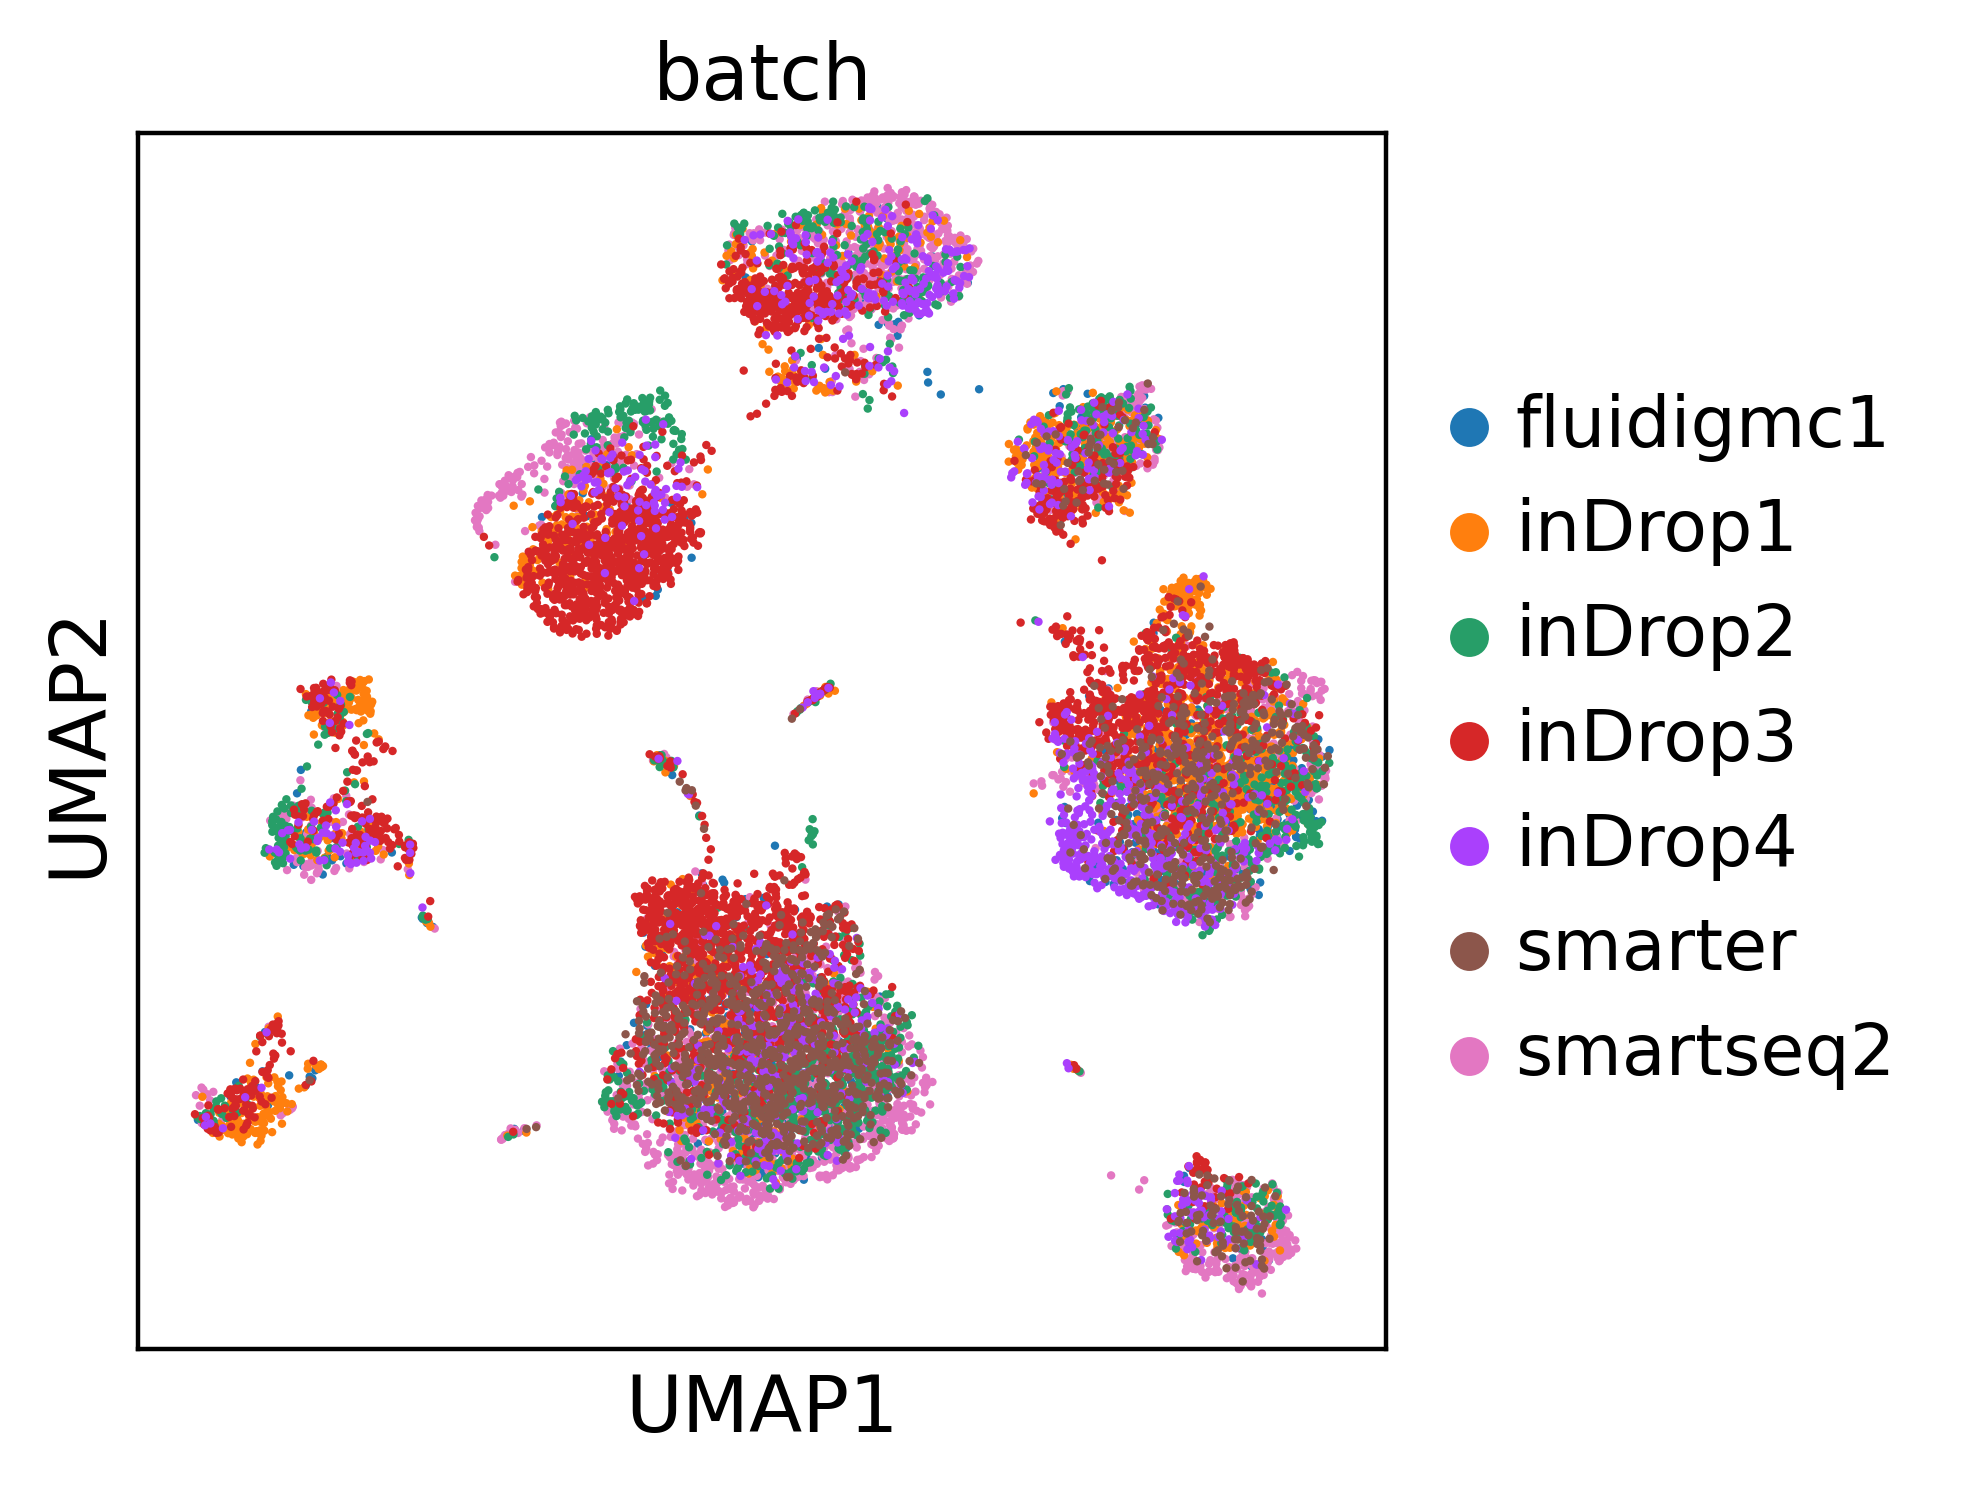

In [14]:
data_latent = embed.get_latent(
    labeled_adata.X, 
    labeled_adata.obs[condition_key].values
)
adata_latent_embed = sc.AnnData(data_latent)
adata_latent_embed.obs['batch'] = labeled_adata.obs[condition_key].tolist()
results_dict_embed = embed.classify(
    labeled_adata.X, 
    labeled_adata.obs[condition_key], 
    metric=class_metric
)
print(results_dict_embed)
sc.pp.neighbors(adata_latent_embed)
sc.tl.umap(adata_latent_embed)
sc.pl.umap(adata_latent_embed, color='batch')

In [15]:
embed_dec.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=eta,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |████----------------| 20.0%  - val_loss: 1075.9899902344 - val_trvae_loss: 1075.9899902344
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 31 clusters.
 |███████-------------| 35.2%  - val_loss: 1076.1052527794 - val_trvae_loss: 1075.6817345252 - val_classifier_loss: 0.4235116175 - val_unlabeled_loss: 0.8082208404 - val_labeled_loss: 0.4227033922
ADJUSTED LR
 |███████-------------| 36.6%  - val_loss: 1074.7428166316 - val_trvae_loss: 1074.3582763672 - val_classifier_loss: 0.3845292009 - val_unlabeled_loss: 0.7745925647 - val_labeled_loss: 0.3837546041
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 182


[{'preds': array(['gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', ...,
       'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma'],
      dtype='<U18'), 'probs': array([0.12, 0.12, 0.13, 0.11, 0.12, 0.11, 0.12, ..., 0.12, 0.12, 0.11,
       0.11, 0.11, 0.11, 0.12], dtype=float32)}]


... storing 'batch' as categorical


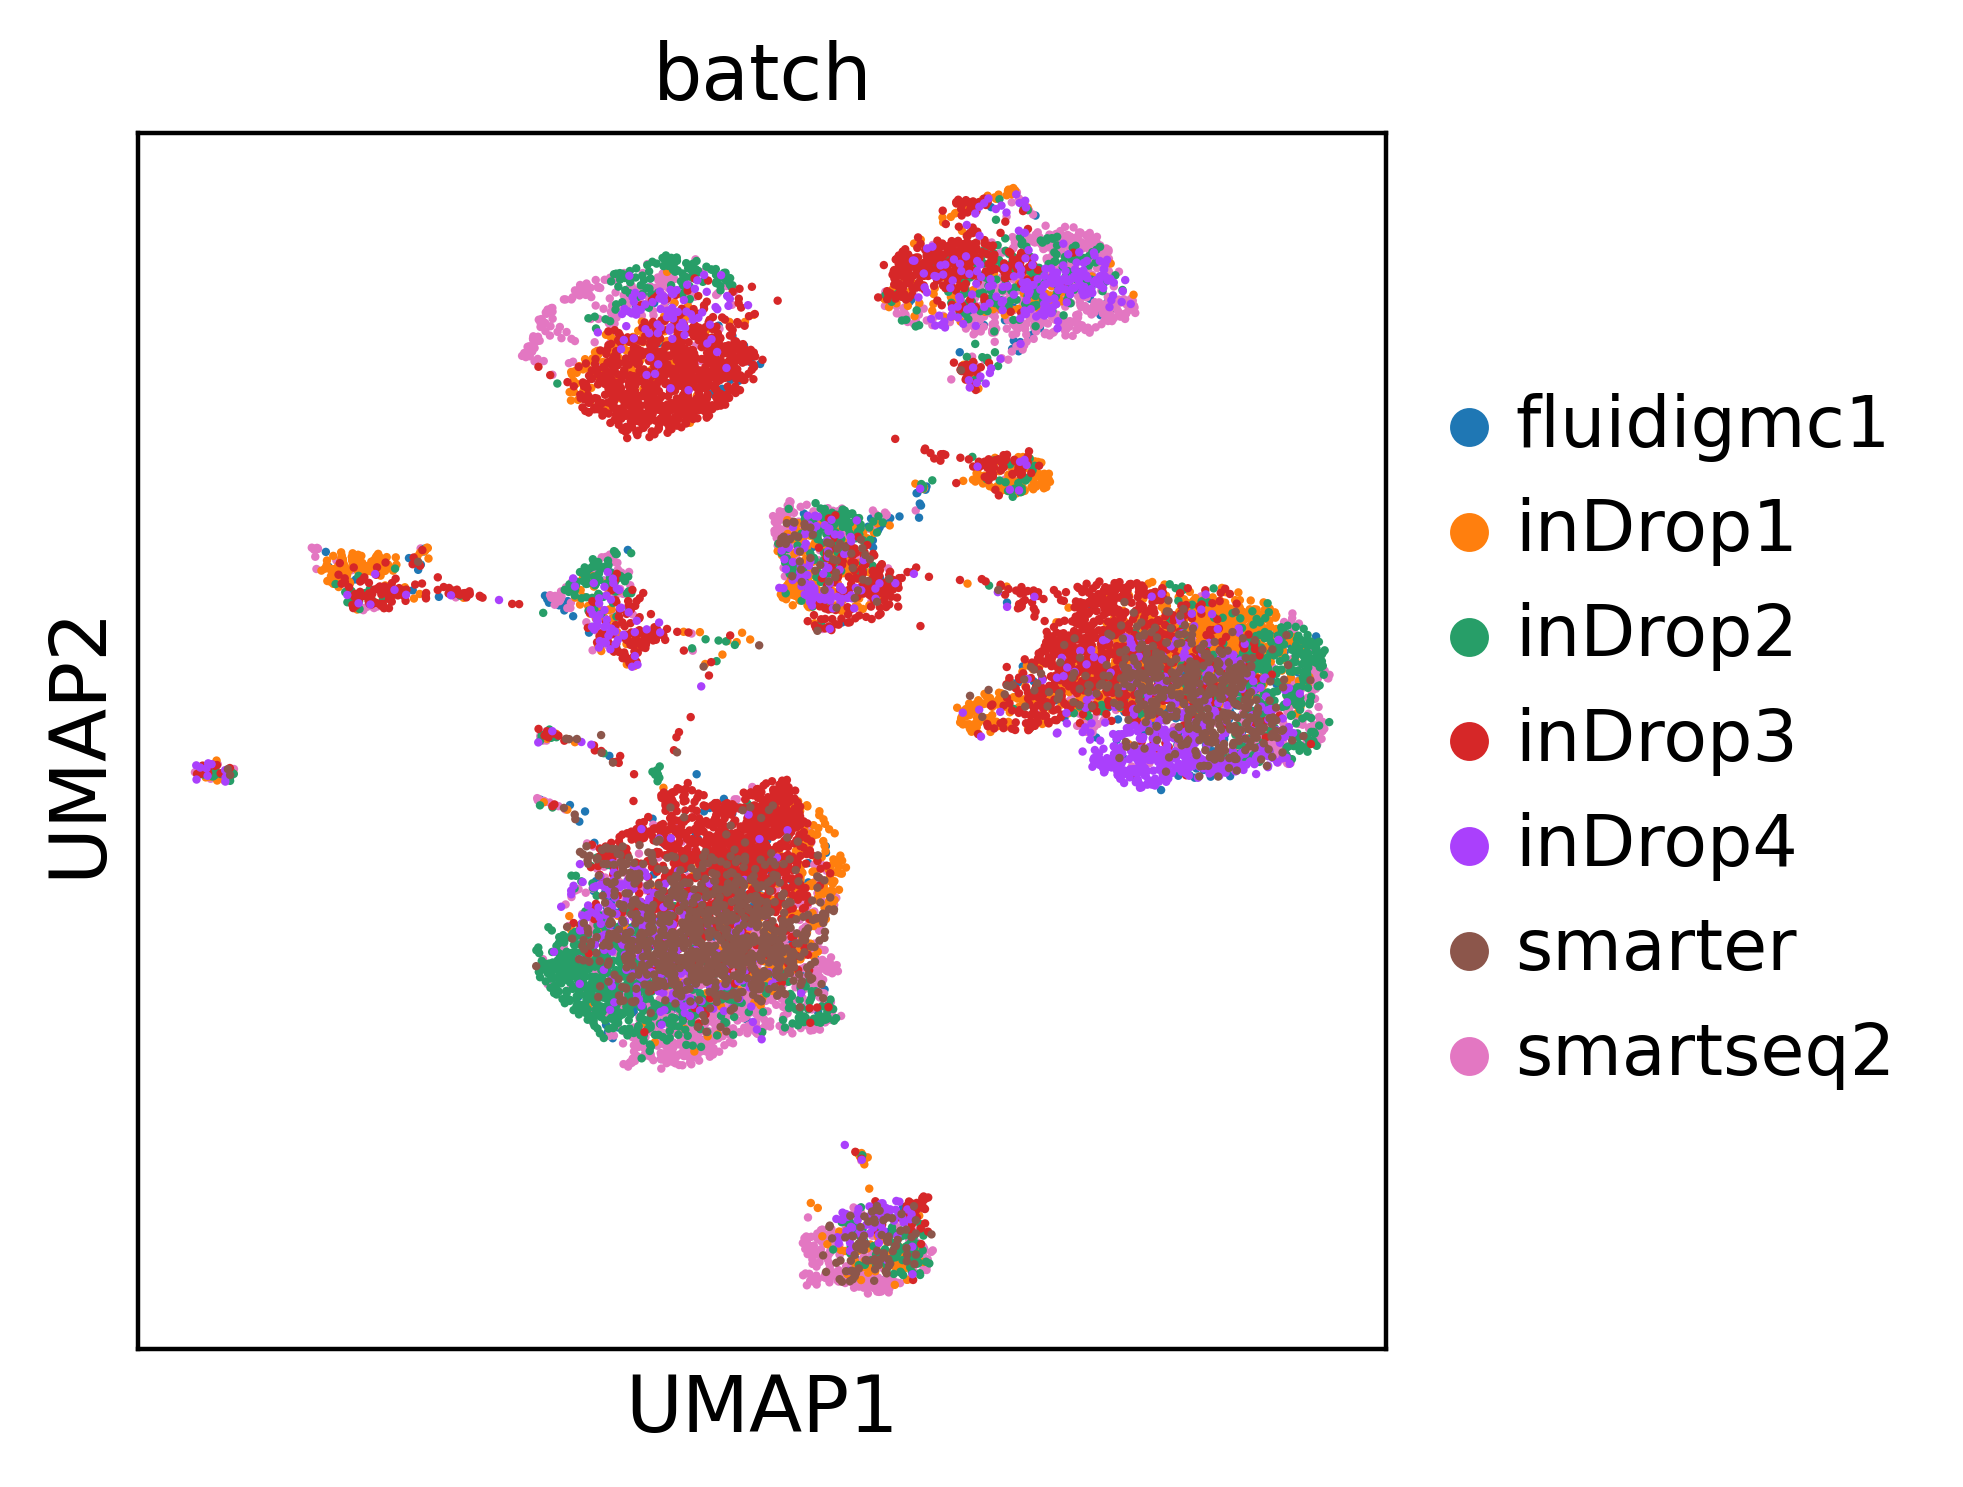

In [16]:
data_latent = embed_dec.get_latent(
    labeled_adata.X, 
    labeled_adata.obs[condition_key].values
)
adata_latent_embed_dec = sc.AnnData(data_latent)
adata_latent_embed_dec.obs['batch'] = labeled_adata.obs[condition_key].tolist()
results_dict_embed_dec = embed_dec.classify(
    labeled_adata.X, 
    labeled_adata.obs[condition_key], 
    metric=class_metric
)
print(results_dict_embed_dec)
sc.pp.neighbors(adata_latent_embed_dec)
sc.tl.umap(adata_latent_embed_dec)
sc.pl.umap(adata_latent_embed_dec, color='batch')

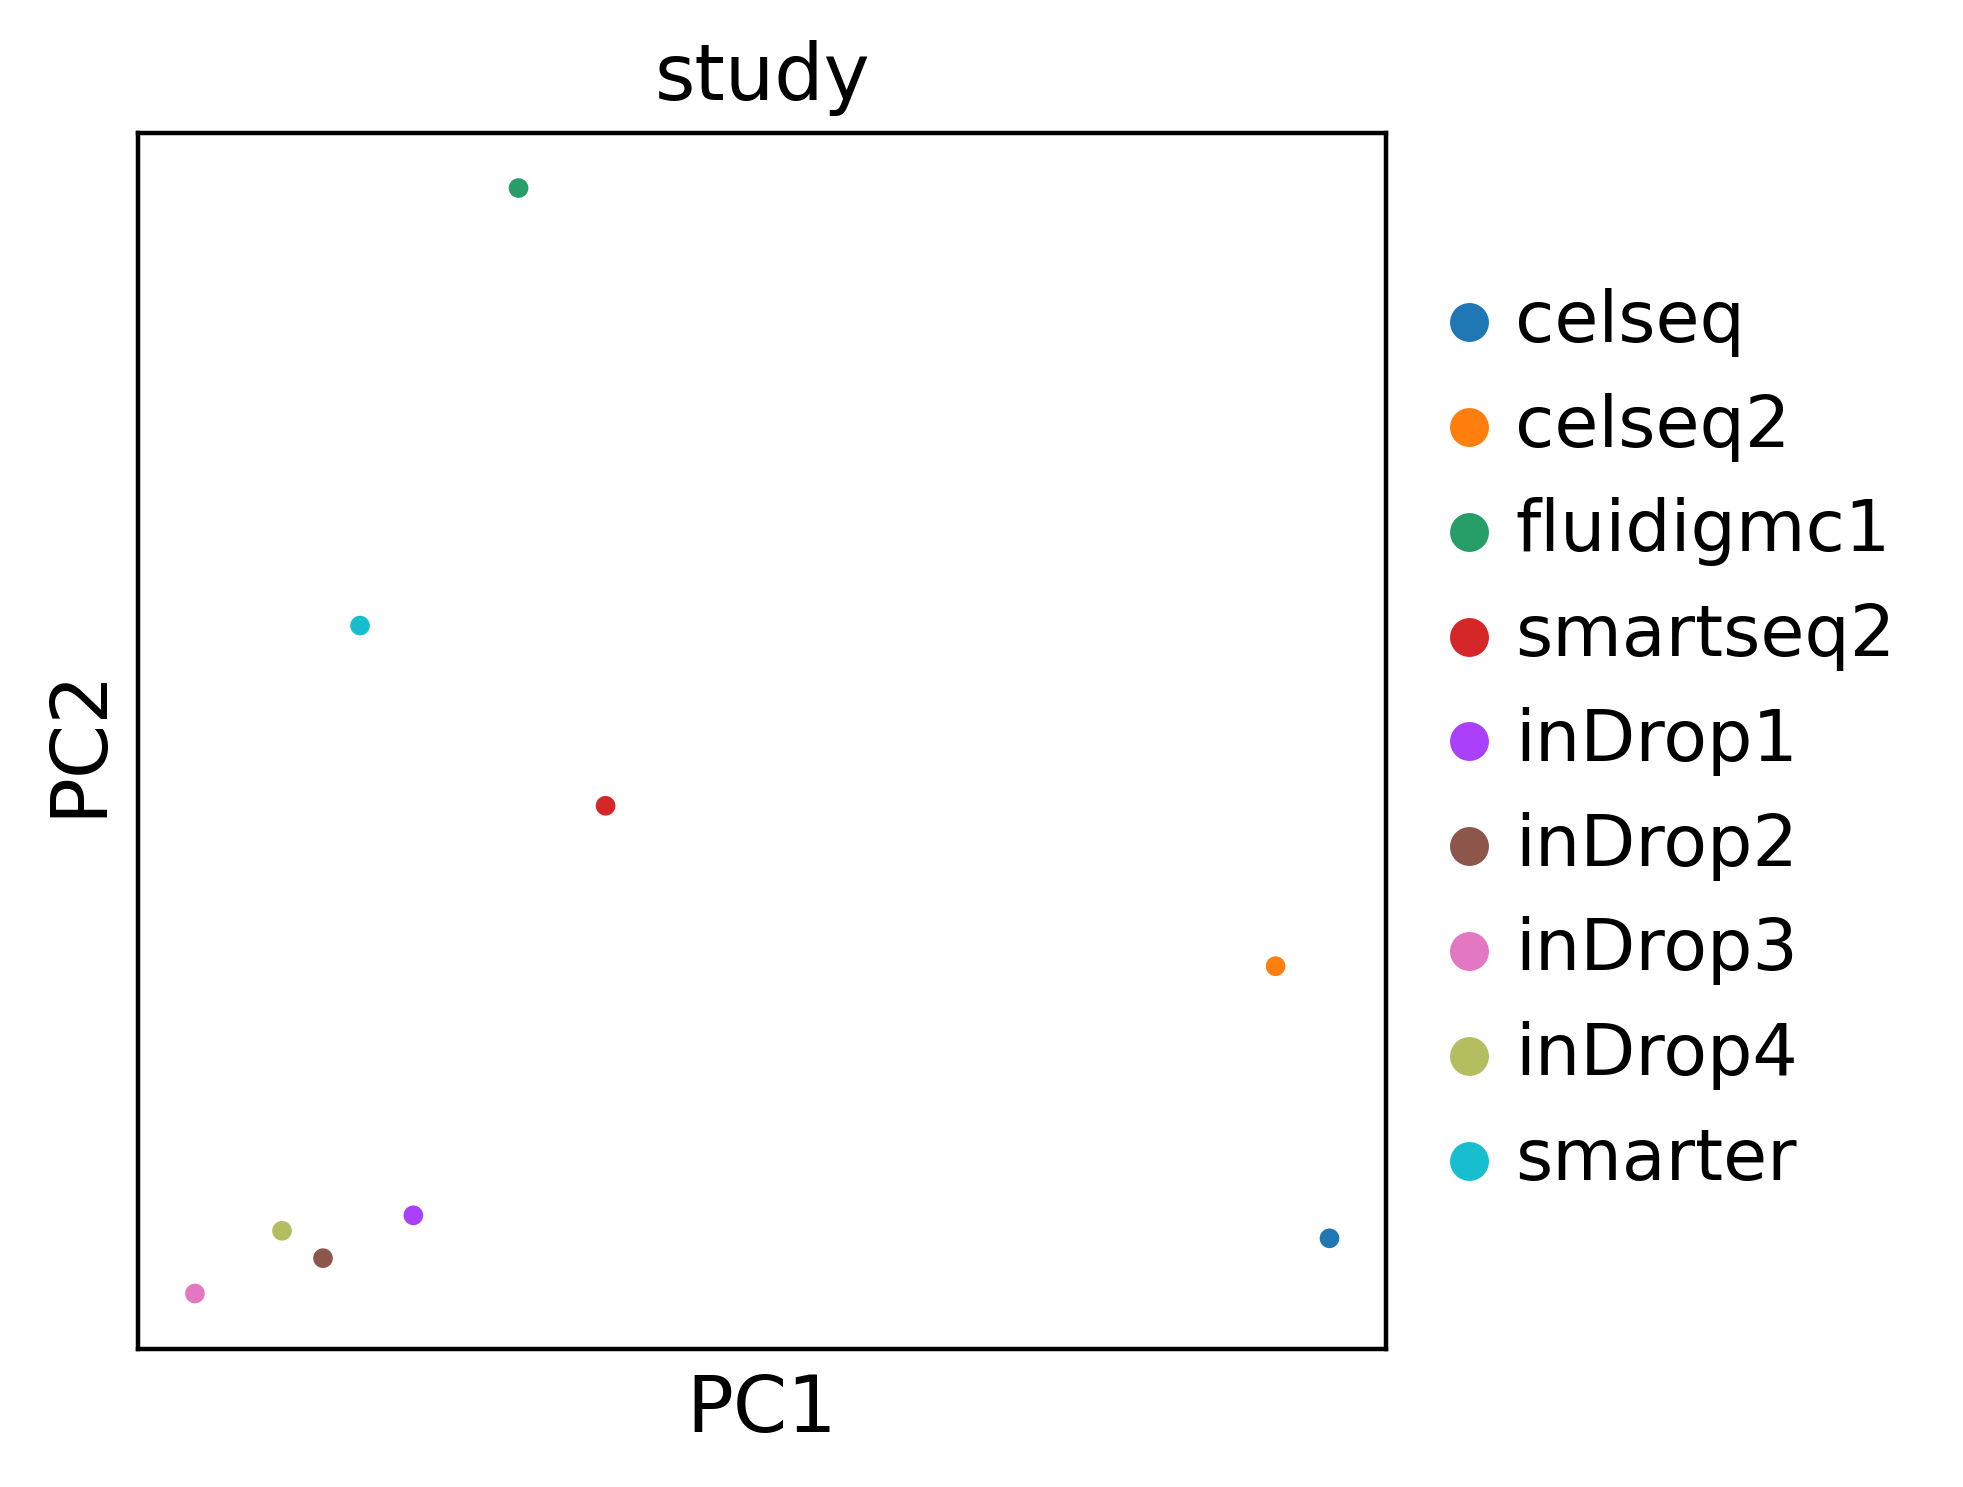

In [21]:
embedding = embed.model.embedding.weight.detach().cpu().numpy()
embedding_adata = sc.AnnData(embedding)
sc.pp.pca(embedding_adata)
embedding_adata.obs[condition_key] = adata.obs[condition_key].unique()
sc.pl.pca(embedding_adata, size=50, color=condition_key)

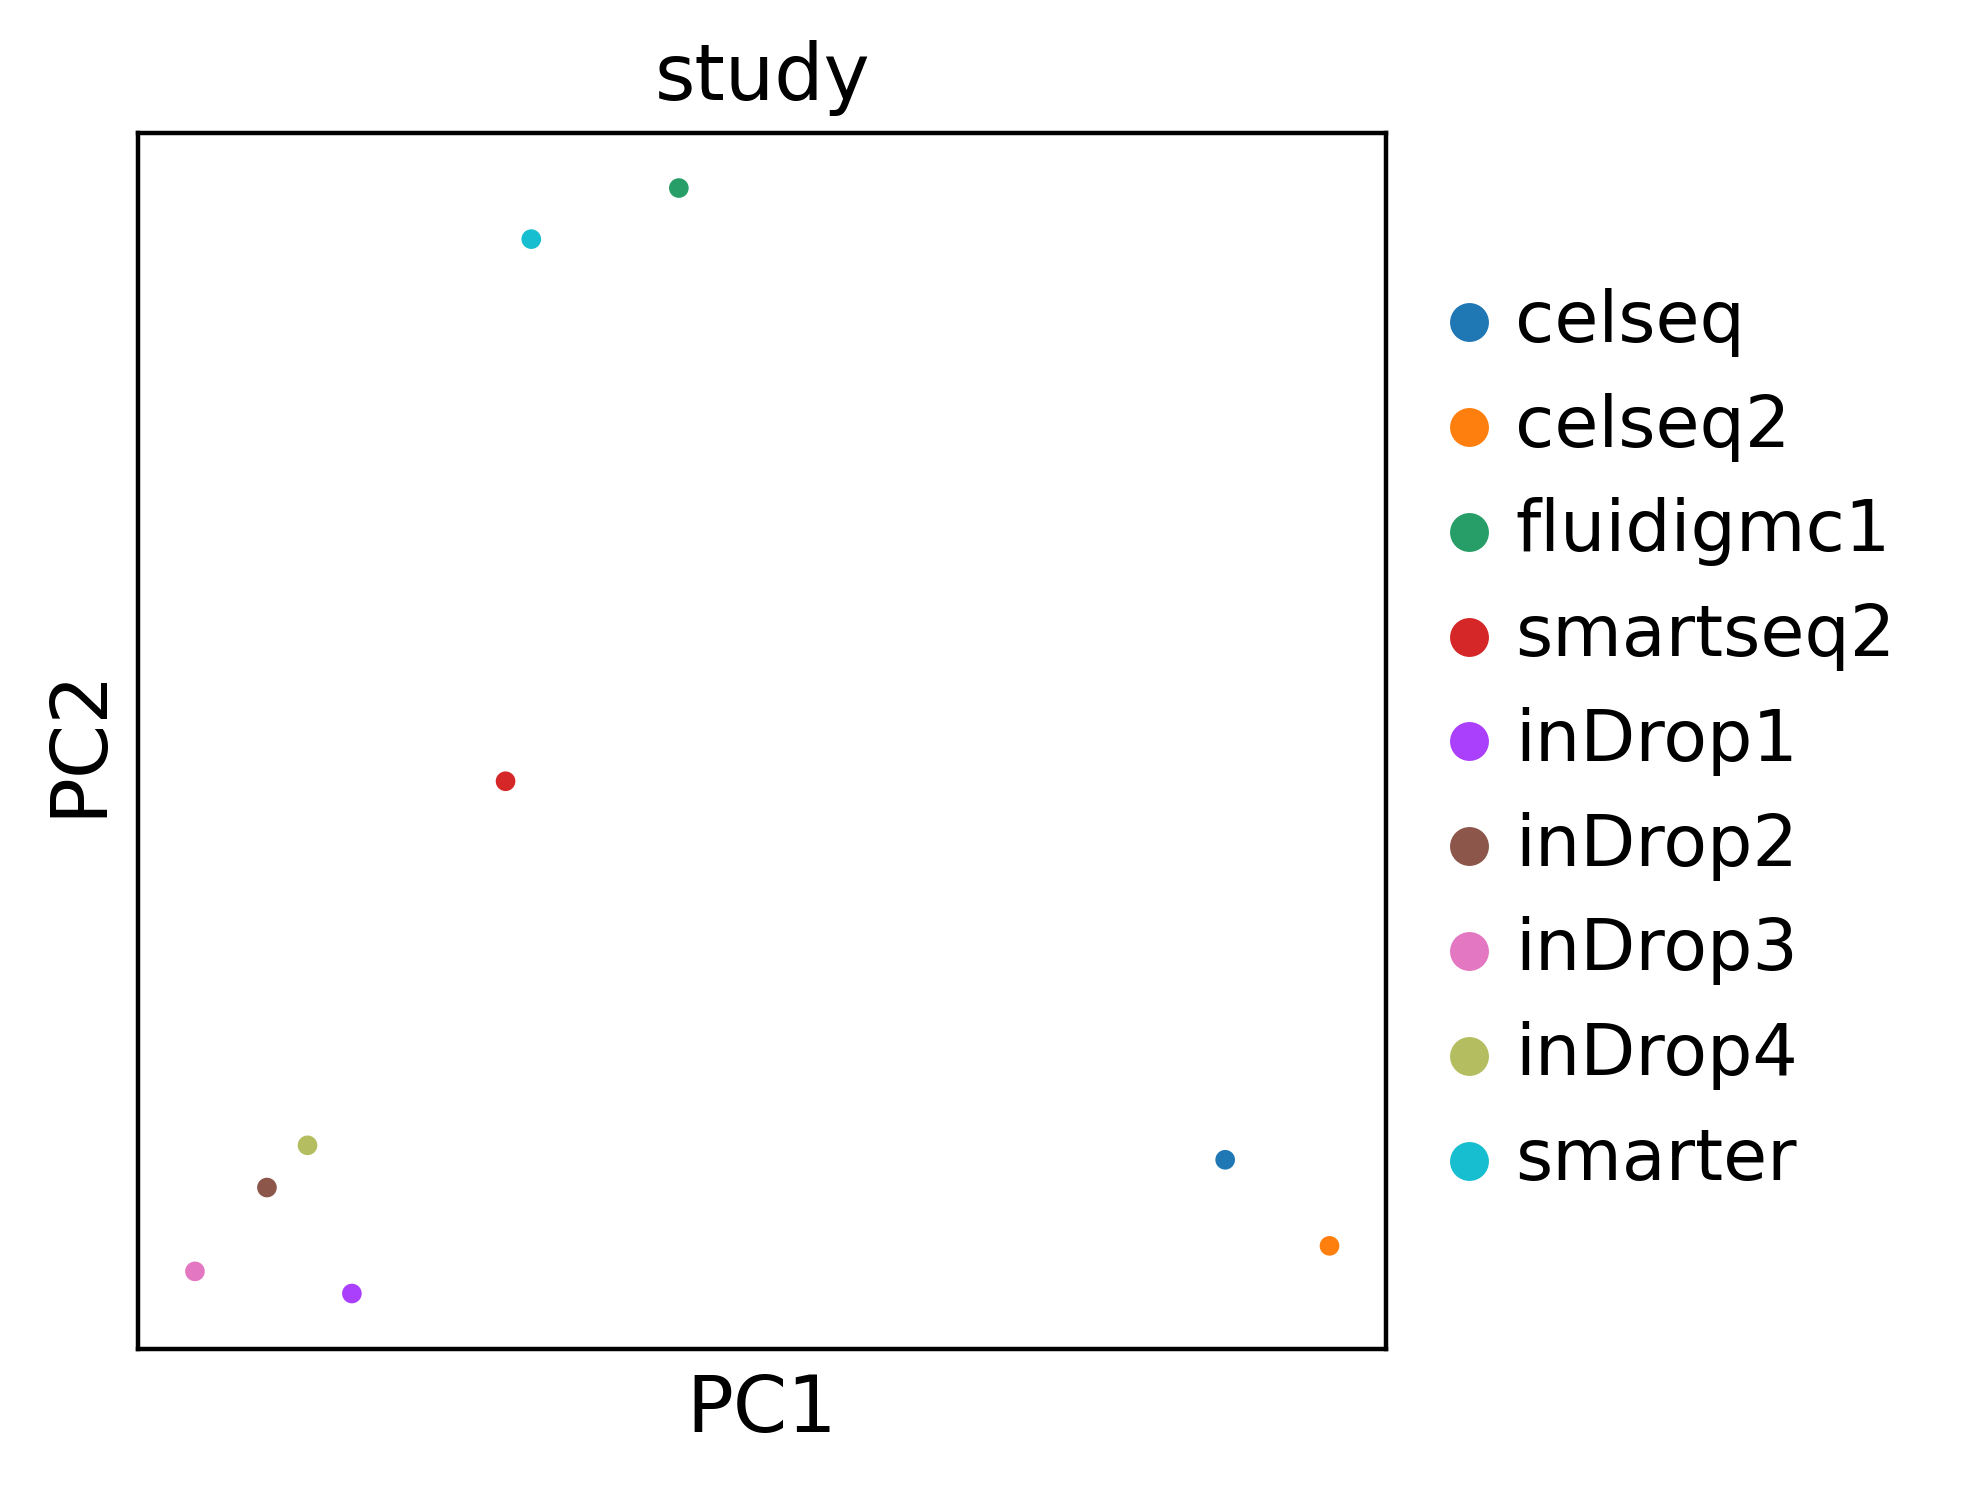

In [22]:
embedding_dec = embed_dec.model.embedding.weight.detach().cpu().numpy()
embedding_dec_adata = sc.AnnData(embedding_dec)
sc.pp.pca(embedding_dec_adata)
embedding_dec_adata.obs[condition_key] = adata.obs[condition_key].unique()
sc.pl.pca(embedding_dec_adata, size=50, color=condition_key)

NameError: name 'adata_latent' is not defined

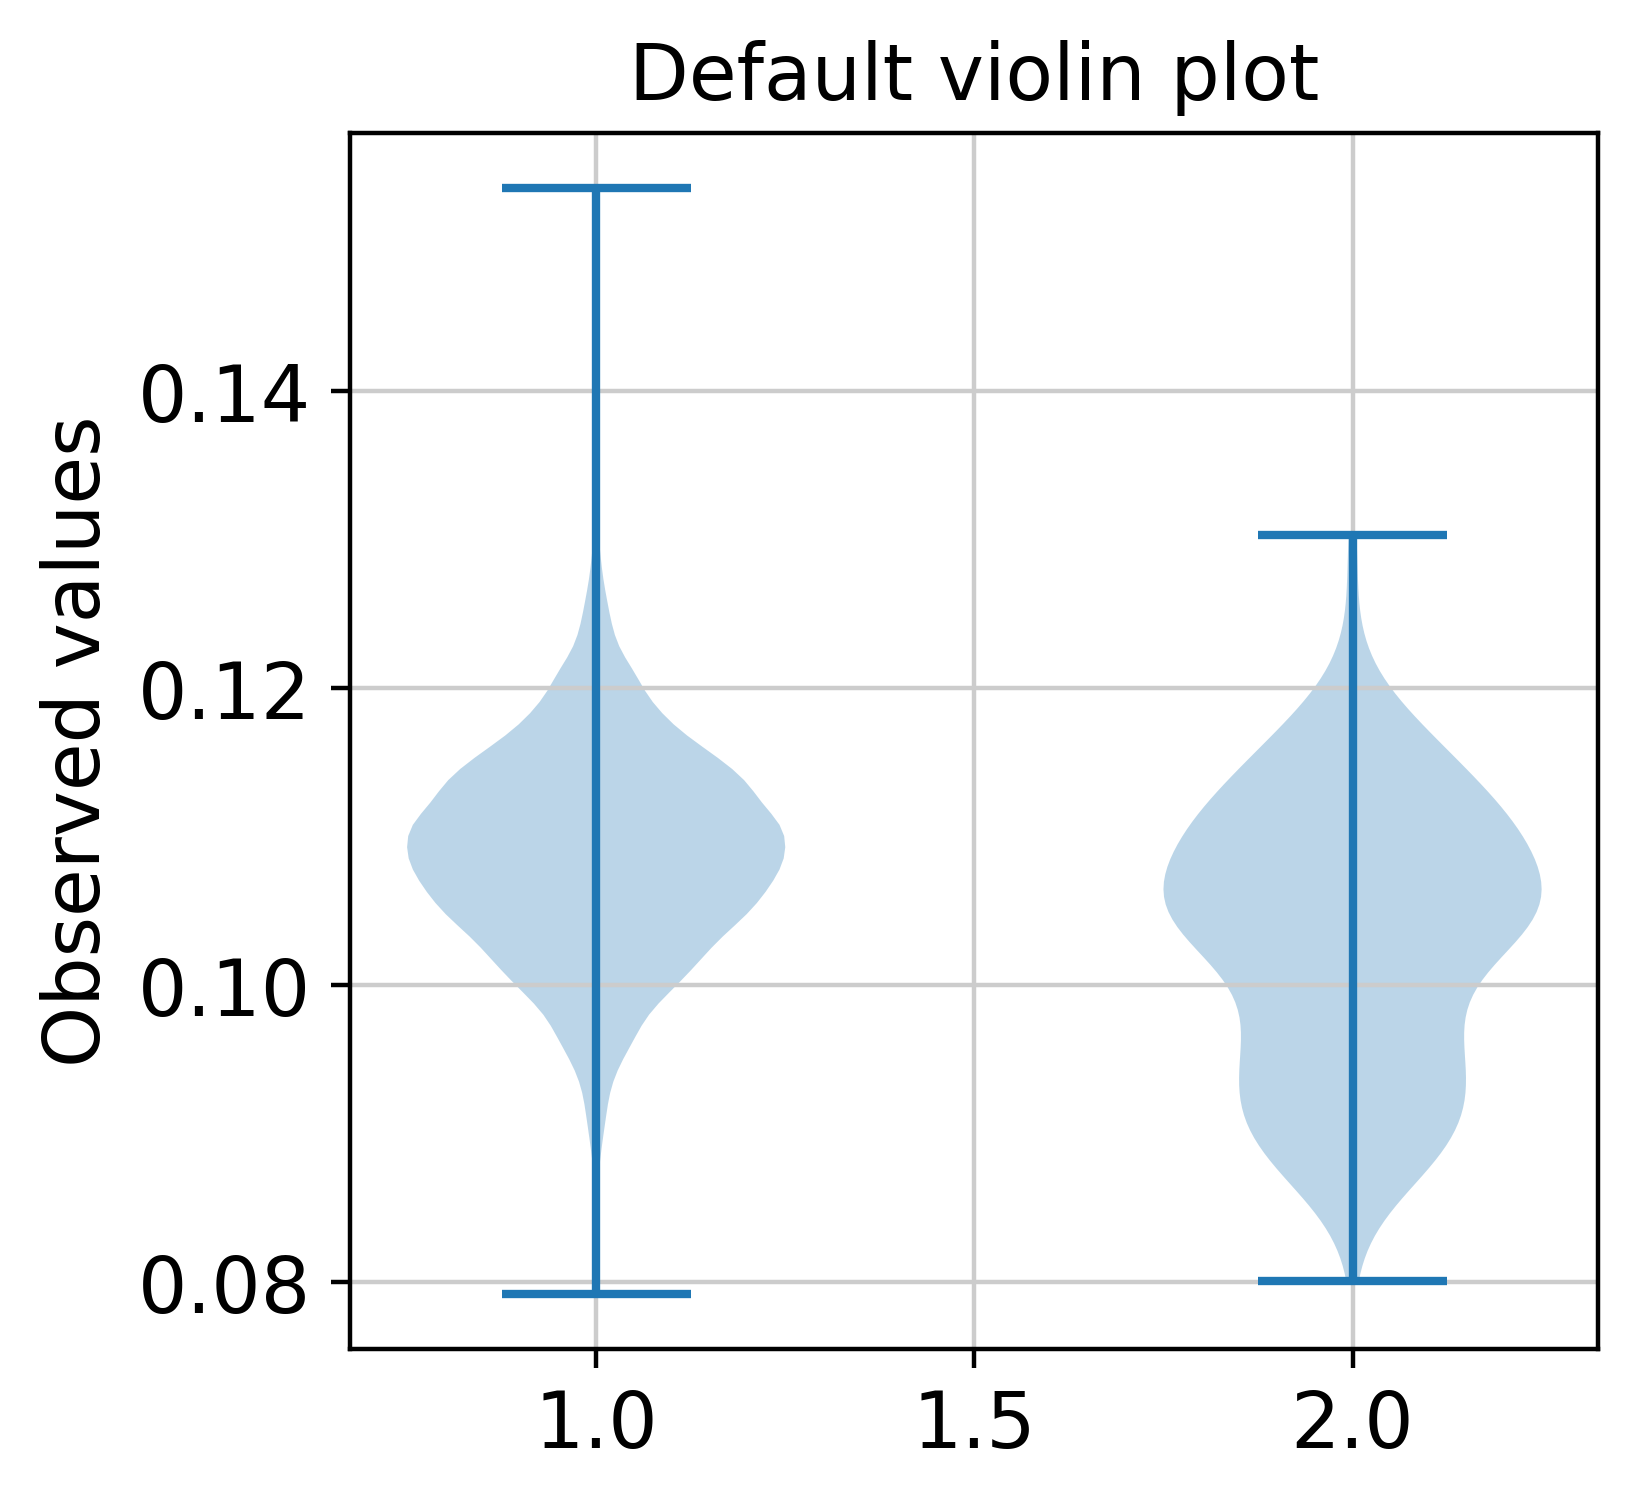

In [28]:
for i in range(len(cell_type_key)):
    preds = results_dict[i]['preds']
    probs = results_dict[i]['probs']

    rep = classification_report(
            y_true=labeled_adata.obs[cell_type_key[i]],
            y_pred=preds,
            labels=np.array(labeled_adata.obs[cell_type_key[i]].unique().tolist())
        )
    correct_probs = probs[preds == labeled_adata.obs[cell_type_key[i]]]
    incorrect_probs = probs[preds != labeled_adata.obs[cell_type_key[i]]]
    data = [correct_probs, incorrect_probs]
            
    #correct, incorrect prob plot
    fig, ax = plt.subplots()
    ax.set_title('Default violin plot')
    ax.set_ylabel('Observed values')
    ax.violinplot(data)
    labels = ['Correct', 'Incorrect']

    checks = np.array(len(labeled_adata) * ['incorrect'])
    checks[preds == labeled_adata.obs[cell_type_key[i]]] = 'correct'
    adata_latent.obs[cell_type_key[i]] = labeled_adata.obs[cell_type_key[i]].tolist()
    adata_latent.obs[f'{cell_type_key[i]}_pred'] = preds.tolist()
    adata_latent.obs[f'{cell_type_key[i]}_bool'] = checks.tolist()

NameError: name 'adata_latent' is not defined

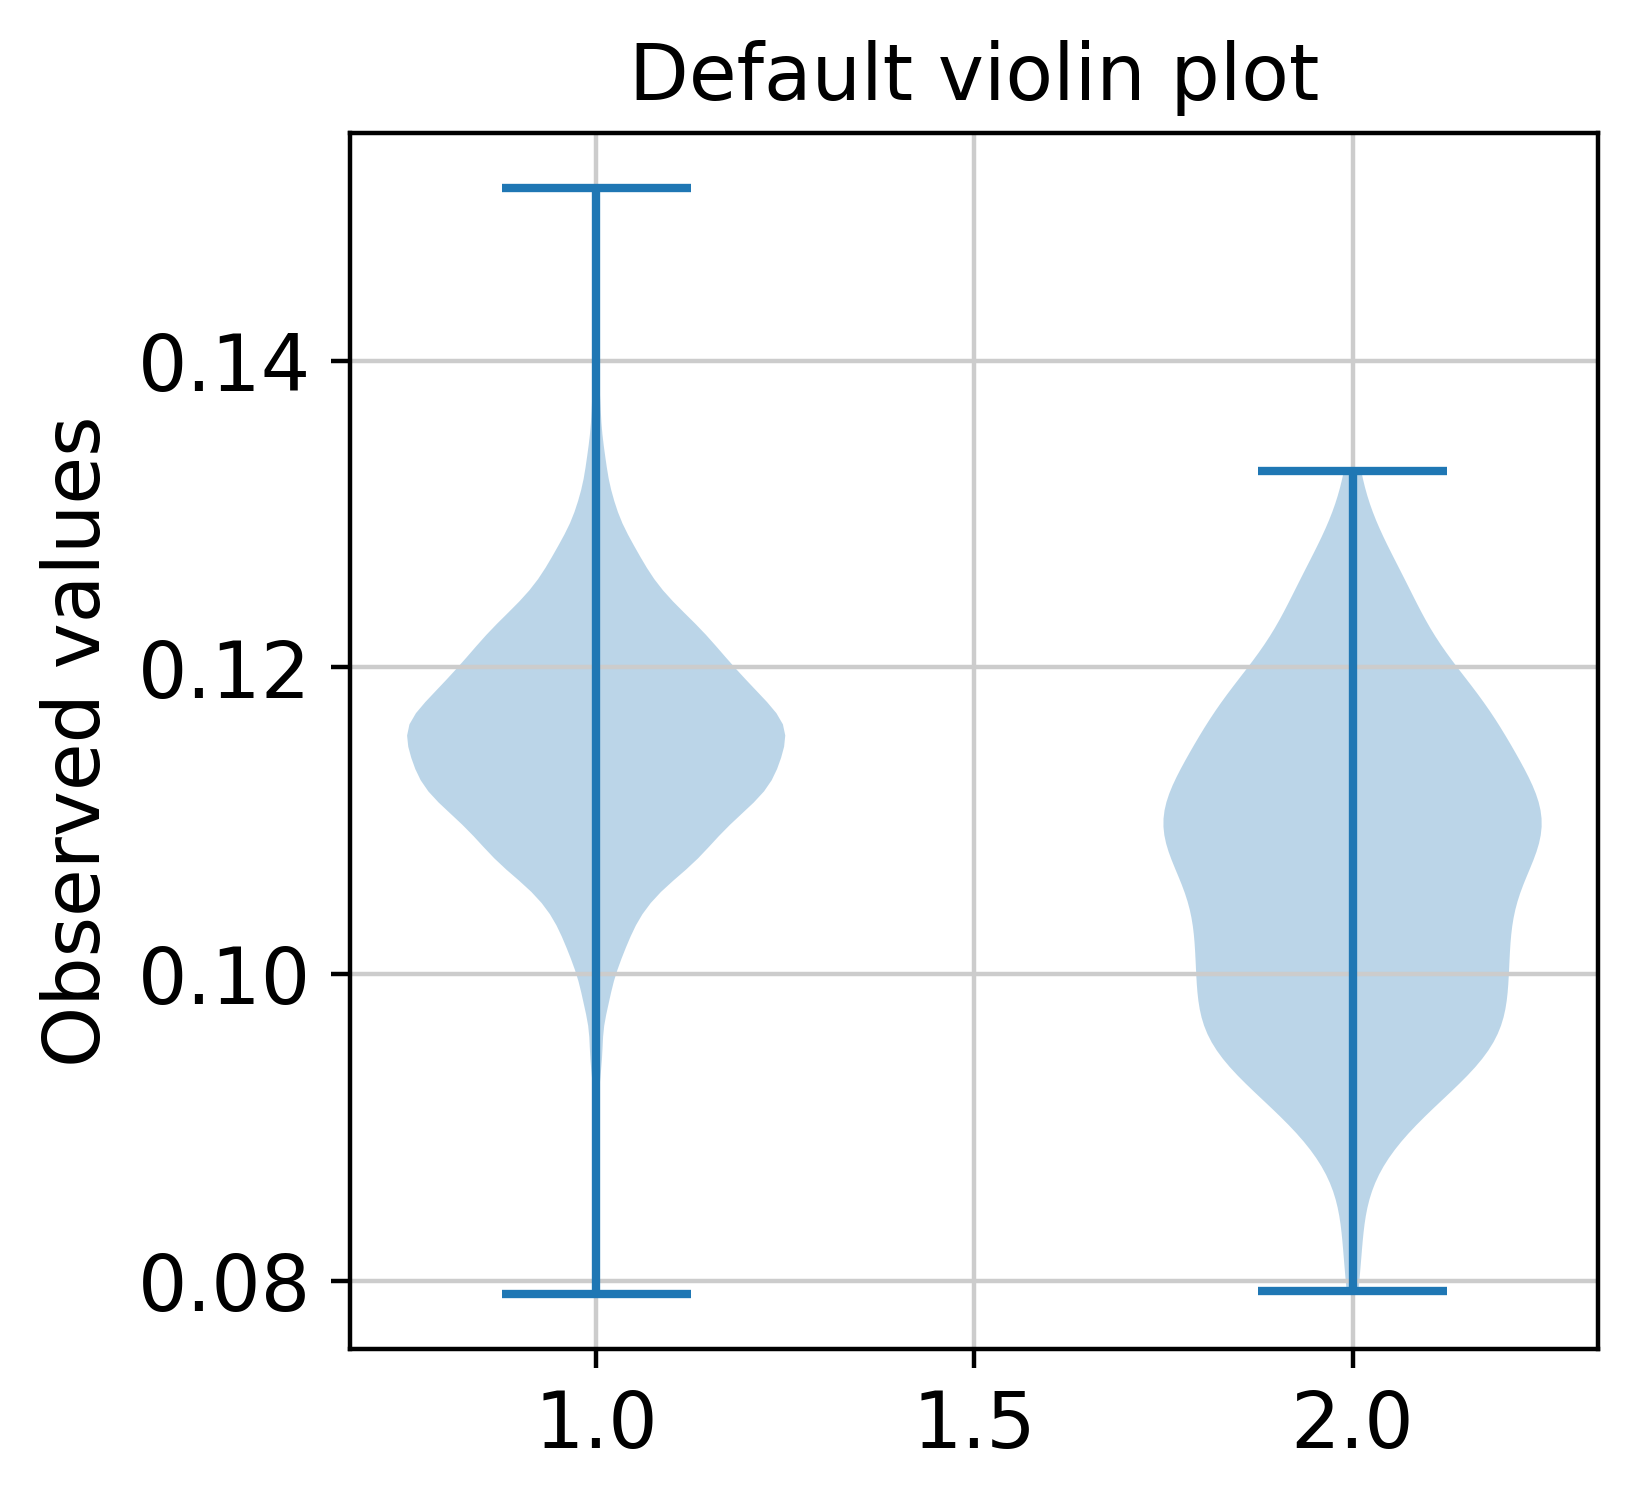

In [30]:
for i in range(len(cell_type_key)):
    preds = results_dict_embed[i]['preds']
    probs = results_dict_embed[i]['probs']

    rep = classification_report(
            y_true=labeled_adata.obs[cell_type_key[i]],
            y_pred=preds,
            labels=np.array(labeled_adata.obs[cell_type_key[i]].unique().tolist())
        )
    correct_probs = probs[preds == labeled_adata.obs[cell_type_key[i]]]
    incorrect_probs = probs[preds != labeled_adata.obs[cell_type_key[i]]]
    data = [correct_probs, incorrect_probs]
            
    #correct, incorrect prob plot
    fig, ax = plt.subplots()
    ax.set_title('Default violin plot')
    ax.set_ylabel('Observed values')
    ax.violinplot(data)
    labels = ['Correct', 'Incorrect']

    checks = np.array(len(labeled_adata) * ['incorrect'])
    checks[preds == labeled_adata.obs[cell_type_key[i]]] = 'correct'
    adata_latent.obs[cell_type_key[i]] = labeled_adata.obs[cell_type_key[i]].tolist()
    adata_latent.obs[f'{cell_type_key[i]}_pred'] = preds.tolist()
    adata_latent.obs[f'{cell_type_key[i]}_bool'] = checks.tolist()